In [7]:
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler, Dataset
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import torchvision.transforms as T

import os
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
from skimage.util import random_noise
from tqdm.notebook import tqdm
from dataclasses import dataclass
import pandas as pd
from PIL import Image

In [8]:
class Config:
    # Training hyperparameters
    batch_size = 6
    learning_rate = 1e-4
    num_epochs = 10
    num_workers = 2
    num_classes = 2  # Airplane or Background
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ann_dir = "/kaggle/input/airplanes/Airplanes_Annotations/Airplanes_Annotations"
    img_dir = "/kaggle/input/airplanes/Images/Images"
    weight_decay = 1e-4 # L2 regularization

config = Config()
    

In [9]:
class AirplaneDataset(Dataset):
    def __init__(self, transforms=None):
        self.transforms = transforms
        self.image_files = [
            f for f in os.listdir(config.img_dir) if f.endswith(('.jpg', '.png'))
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(config.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        ann_file = os.path.join(config.ann_dir, f"{os.path.splitext(img_name)[0]}.csv")
        annotations = pd.read_csv(ann_file, header=None)

        num_boxes = int(annotations.iloc[0, 0])  # First row is the number of boxes

        # Skip if no boxes are found
        if num_boxes == 0:
            boxes = torch.empty(0, 4, dtype=torch.float32)  
            labels = torch.empty(0, dtype=torch.int64)  
        else:
            boxes = annotations.iloc[1:1 + num_boxes].values
            boxes = [[float(coord) for coord in box_str.split()] for box_str in boxes.reshape(-1)]
            boxes = torch.tensor(boxes, dtype=torch.float32)

            if boxes.dim() == 1:  # If boxes is 1-dimensional, add a dimension
                boxes = boxes.unsqueeze(0)

            

        # Create target dictionary
        target = {
            "boxes": boxes[:, :4],  # [x_min, y_min, x_max, y_max]
            "labels": torch.ones((num_boxes,), dtype=torch.int64),  # Airplane label
        }

        if self.transforms:
            image = self.transforms(image)
        else:  # if no transforms are specified, apply ToTensor()
            image = T.ToTensor()(image)

        return image, target    

In [10]:
transform = T.Compose([
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
        T.ToTensor()  # Convert image to tensor
    ])

dataset = AirplaneDataset(transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=config.batch_size,
                          shuffle=True, collate_fn=lambda x: tuple(zip(*x)),
                          num_workers=config.num_workers)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size,
                         shuffle=False, collate_fn=lambda x: tuple(zip(*x)),
                         num_workers=config.num_workers)

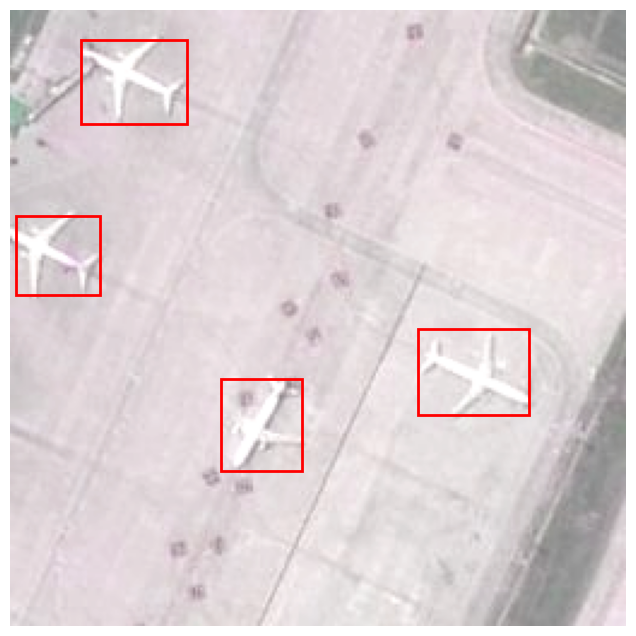

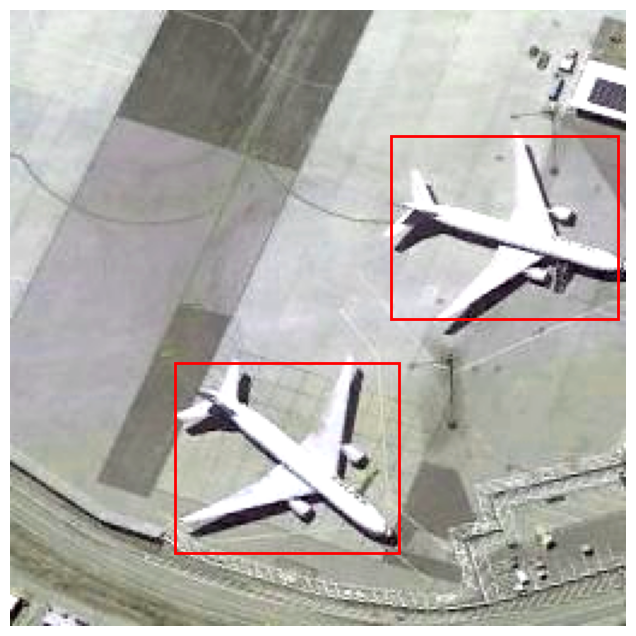

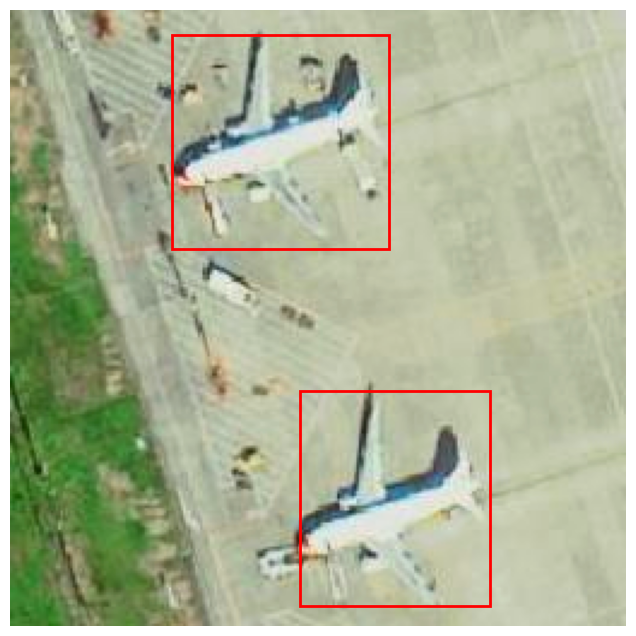

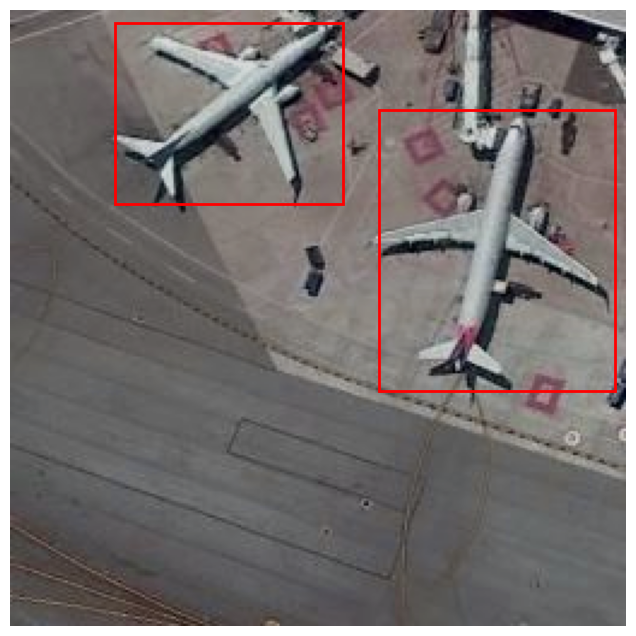

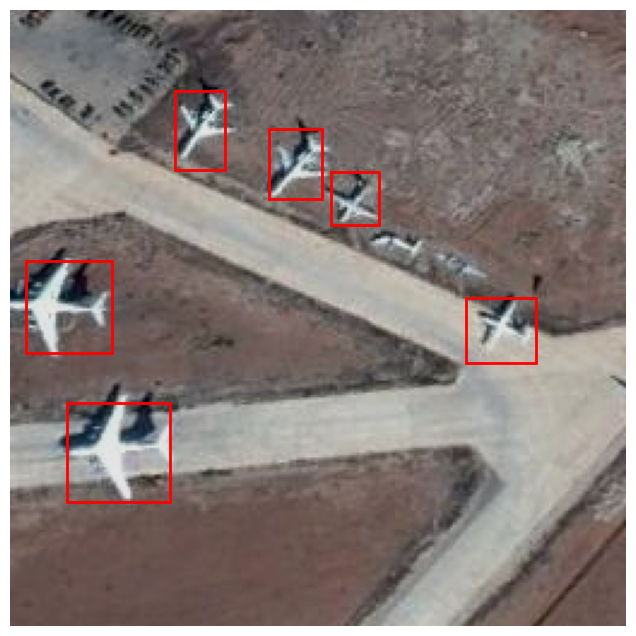

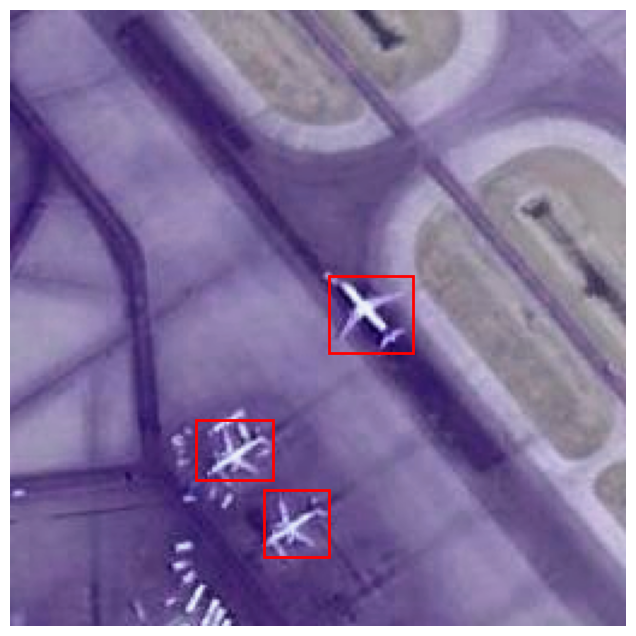

In [11]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Function to plot images with bounding boxes
def plot_images_with_boxes(images, targets, batch_size):
    for i in range(batch_size):
        image = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert from Tensor to numpy (H, W, C)
        image = (image * 255).astype("uint8")  # Denormalize the image

        # Plot the image
        plt.figure(figsize=(8, 8))
        plt.imshow(image)

        # Get the ground truth boxes
        boxes = targets[i]["boxes"].cpu().numpy()

        # Plot each box
        for box in boxes:
            x_min, y_min, x_max, y_max = box
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                              fill=False, color="red", linewidth=2))

        plt.axis('off')
        plt.show()

# Visualize a batch of images from the train_loader
images, targets = next(iter(train_loader))  # Get the first batch
plot_images_with_boxes(images, targets, batch_size=config.batch_size)


In [12]:
def train_model(model, train_loader, test_loader, optimizer):
    model.to(config.device)

    for epoch in range(config.num_epochs):
        model.train()
        total_loss = 0
        for images, targets in train_loader:

            images = [img.to(config.device) for img in images]
            targets = [{k: v.to(config.device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()
            total_loss += losses.item()

        print(f"Epoch {epoch + 1}/{config.num_epochs}, Loss: {total_loss:.4f}")
        
        results = evaluate_model_multiple_iou_thresholds(model, test_loader)

        print("mAP for IoU thresholds:")
        iou_thresholds = [0.5, 0.75, 0.9]
        
        for iou, key in zip(iou_thresholds, ['map_50', 'map_75', 'map_90']):
            value = results.get(key, -1)  
            print(f"IoU {iou}: {value:.4f}")

In [13]:
!pip install torchmetrics

In [14]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def evaluate_model_multiple_iou_thresholds(model, dataloader):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5, 0.75, 0.9])  # Add multiple IoU thresholds
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(config.device) for img in images]
            targets = [{k: v.to(config.device) for k, v in t.items()} for t in targets]
            outputs = model(images)
            
            metric.update(outputs, targets)
    
    results = metric.compute()
    return results  # Returns results with mAP for each IoU threshold


In [15]:
import matplotlib.patches as patches

def visualize_image(img, gt_boxes, pred_boxes, pred_scores):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    # Draw ground truth boxes in green
    for box in gt_boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                  linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    # Draw predicted boxes in red
    for box, score in zip(pred_boxes, pred_scores):
        if score > 0.5:  # Only show predictions with confidence > 50%
            x_min, y_min, x_max, y_max = box
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                      linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min, f'{score:.2f}', color='r', fontsize=12)

    plt.axis("off")
    plt.show()


In [16]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    images_to_show = num_images

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(config.device) for img in images]
            outputs = model(images)

            for img, target, output in zip(images, targets, outputs):
                # Convert image tensor to PIL image for visualization
                img = F.to_pil_image(img.cpu())
                gt_boxes = target["boxes"].cpu().numpy()
                pred_boxes = output["boxes"].cpu().numpy()
                pred_scores = output["scores"].cpu().numpy()

                # Visualize image with ground truth and predicted boxes
                visualize_image(img, gt_boxes, pred_boxes, pred_scores)

                images_to_show -= 1
                if images_to_show == 0:
                    return


In [19]:
import torchvision
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.anchor_utils import AnchorGenerator

def get_retinanet_model():
    backbone = resnet_fpn_backbone(backbone_name='resnet18', weights='DEFAULT')
    model = RetinaNet(backbone=backbone, num_classes=config.num_classes)
    return model

In [20]:
model = get_retinanet_model()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=config.weight_decay)

train_model(model, train_loader, test_loader, optimizer)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s] 


Epoch 1/10, Loss: 108.2474


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


mAP for IoU thresholds:
IoU 0.5: 0.4361
IoU 0.75: 0.0487
IoU 0.9: -1.0000
Epoch 2/10, Loss: 79.9523
mAP for IoU thresholds:
IoU 0.5: 0.5269
IoU 0.75: 0.1139
IoU 0.9: -1.0000
Epoch 3/10, Loss: 62.0167
mAP for IoU thresholds:
IoU 0.5: 0.6541
IoU 0.75: 0.1925
IoU 0.9: -1.0000
Epoch 4/10, Loss: 59.3860
mAP for IoU thresholds:
IoU 0.5: 0.6583
IoU 0.75: 0.2375
IoU 0.9: -1.0000
Epoch 5/10, Loss: 52.2071
mAP for IoU thresholds:
IoU 0.5: 0.7136
IoU 0.75: 0.2474
IoU 0.9: -1.0000
Epoch 6/10, Loss: 48.7602
mAP for IoU thresholds:
IoU 0.5: 0.7499
IoU 0.75: 0.3157
IoU 0.9: -1.0000
Epoch 7/10, Loss: 45.1293
mAP for IoU thresholds:
IoU 0.5: 0.7536
IoU 0.75: 0.3292
IoU 0.9: -1.0000
Epoch 8/10, Loss: 42.2332
mAP for IoU thresholds:
IoU 0.5: 0.7809
IoU 0.75: 0.3076
IoU 0.9: -1.0000
Epoch 9/10, Loss: 39.6986
mAP for IoU thresholds:
IoU 0.5: 0.7808
IoU 0.75: 0.3623
IoU 0.9: -1.0000
Epoch 10/10, Loss: 37.9494
mAP for IoU thresholds:
IoU 0.5: 0.7886
IoU 0.75: 0.3980
IoU 0.9: -1.0000


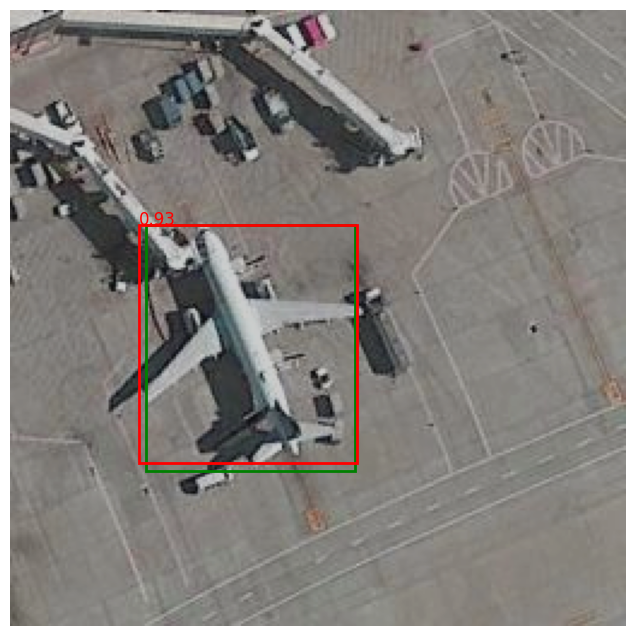

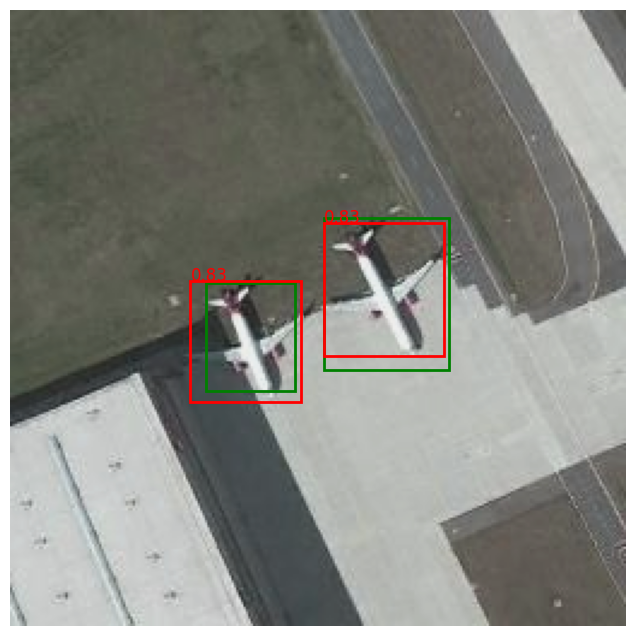

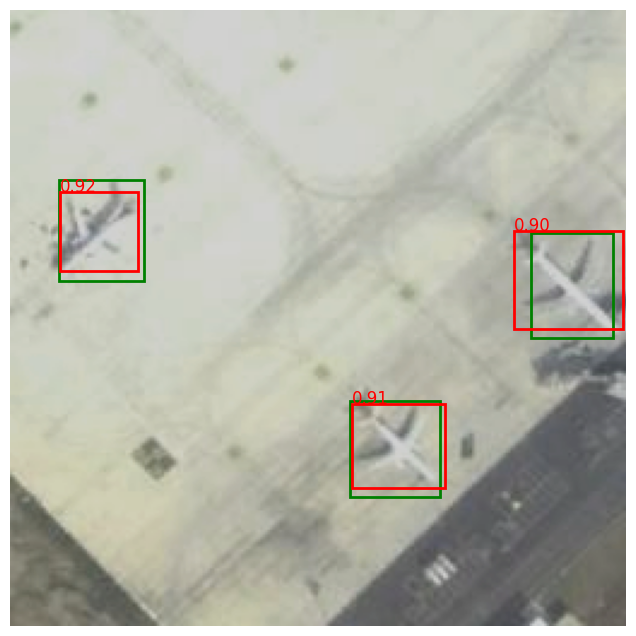

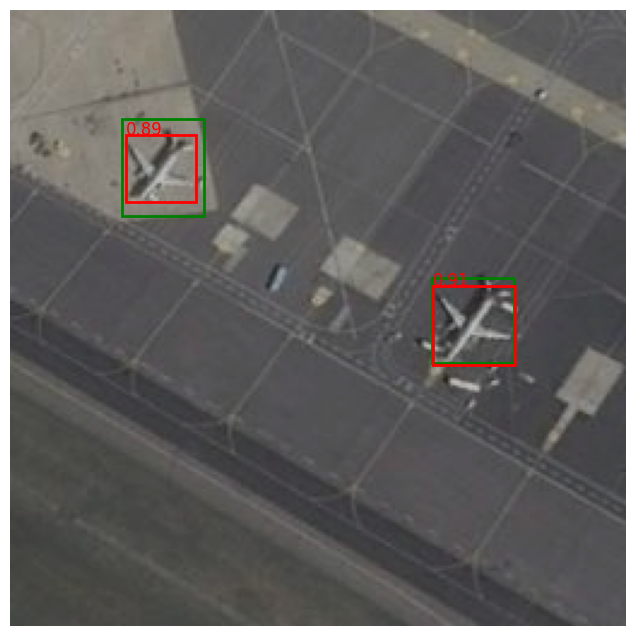

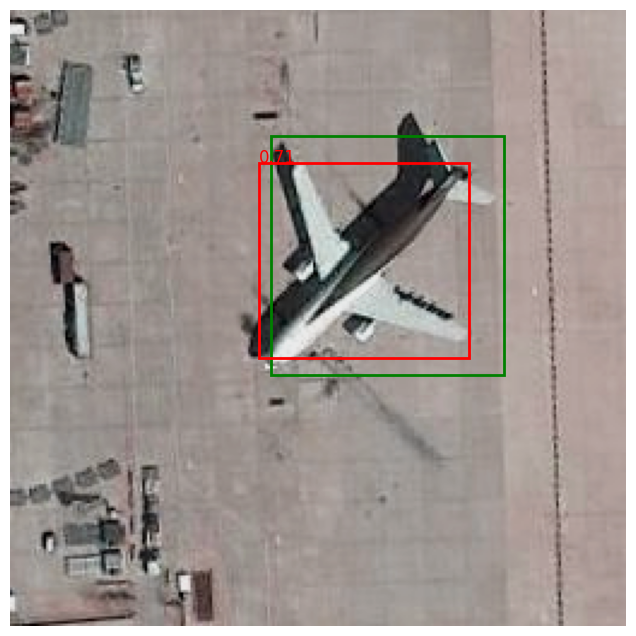

In [21]:
visualize_predictions(model, test_loader, num_images=5)